C:\Users\Toktam\Documents\GitHub\BrainMRIAnalysis\MultiInstanceLearning\MakeDataset.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target  = torch.tensor(target_bags).clone().detach()


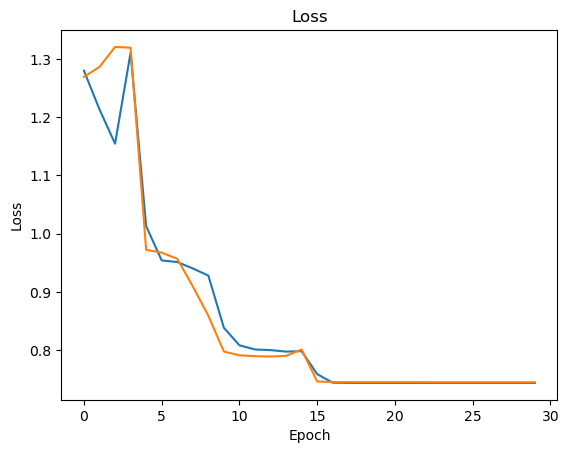

In [2]:
import MRIDataRead
import MakeDataset
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
root = "D://datasets//MRI_Mahdieh_Datasets//task1//"
newdim = 224
mri_data_read = MRIDataRead.MRIDataRead(root,newdim)
total_mris,targets,channel_num = mri_data_read.ReadData()
bagsize = 4
instance_num = 50
data_bags, target_bags = mri_data_read.GenBags(total_mris,targets,bagsize,instance_num)
data_bags = np.array(data_bags)
target_bags = np.array(target_bags)
target_bags = torch.from_numpy(target_bags).long()
target = F.one_hot(target_bags)
target_bags = target[:, 1:]
train_data, test_data, train_labels, test_labels = train_test_split(data_bags, target_bags, test_size=0.2)
train_dataset = MakeDataset.MakeDataset(train_data,train_labels)
test_dataset = MakeDataset.MakeDataset(test_data,test_labels )
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import MILNetV2
%matplotlib inline
model = MILNetV2.MILNetV2(bagsize)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07)
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define the number of training epochs
num_epochs = 30
loss_values = []
validation_loss_values = []
# Iterate over the training epochs
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    loss1 = []
    
    # Iterate over the batches of data from the train data loader
    for batch_idx, data in enumerate(train_data_loader):
        # Move the data to the device
        data = [tensor.to(device, dtype=torch.float32) for tensor in data]
        
        # Separate the inputs and targets
        inputs, targets = data
        inputs =inputs.reshape(-1,bagsize,channel_num,newdim,newdim)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, targets)
        # Store the loss value
        loss1.append(loss.item())
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss
    val_loss = 0.0
    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        for val_data in test_data_loader:
            val_data = [tensor.to(device, dtype=torch.float32) for tensor in val_data]
            val_inputs, val_targets = val_data
            val_inputs = val_inputs.reshape(-1, bagsize, channel_num, newdim, newdim)

            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    # Compute the average validation loss
    val_loss /= len(test_data_loader)
    # Append the validation loss to a list or store it as needed
    validation_loss_values.append(val_loss)

    # Set the model back to training mode
    model.train()
    loss1 = np.array(loss1)
    loss_values.append(np.mean(loss1))
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Plot the loss values
plt.plot(loss_values, label='Training Loss')
plt.plot(validation_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend
plt.legend()
plt.show()
